# Prepare Databases for Model Deployment

In [3]:
import sys
import pandas as pd
import eikon as ek
import numpy as np
import os
from time import sleep
from tqdm import tqdm
import datetime
import json
from functions import *
from pytz import timezone # set timezone
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
ek.set_app_key('****')

if ek.get_port_number() == '9000':
    pass
else:
    print('No Connection with Eikon! RESTART THAT BITCH!')

#display
class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)
    
# sp500_symbols = list(ek.get_data(['0#.SPX'], 'TR.RIC')[0]['RIC'])
# dowjones_symboles = list(ek.get_data(['0#.DJI'], 'TR.RIC')[0]['RIC'])  
# nasdaq100_symbols = list(ek.get_data(['0#.NDX'], 'TR.RIC')[0]['RIC'])
# unique_index_symbols = list(np.unique(sp500_symbols + dowjones_symboles + nasdaq100_symbols))

# stock_universe = [i.split('.')[0] for i in list(np.unique(sp500_symbols + dowjones_symboles + nasdaq100_symbols))]
# with open('./stock_universe.json', 'w', encoding='utf-8') as f:
#         json.dump(stock_universe, f, ensure_ascii=False, indent=4)

### Get Closing Prices (2021)

In [2]:
def get_prices(symbols):
#     end = datetime.datetime.now(timezone('US/Eastern'))
#     start = end - datetime.timedelta(days = 1)
#     start = start.strftime('%Y-%m-%dT%H:%M:%S')
#     end = end.strftime('%Y-%m-%dT%H:%M:%S')
    end = datetime.datetime.now(timezone('US/Eastern'))
    start = datetime.datetime(2021,1,1)
    start = start.strftime('%Y-%m-%d')
    end = end.strftime('%Y-%m-%d')
    prices = pd.DataFrame()
    columns_name = {'CLOSE': 'close','OPEN': 'open', 'VOLUME': 'volume','HIGH': 'high', 'LOW': 'low','Date': 'date', 'Security': 'ticker'}
    for symbol in tqdm(symbols):
        df = ek.get_timeseries([symbol],
                                    start_date=start,
                                    end_date=end,
                                    normalize= True,
                                    fields= '*',
                                    calendar = 'tradingdays',
                                    interval = 'daily')
        df0 = df.loc[df.Security == symbol, ['Date','Field', 'Value']]
        df_pivot = df0.pivot(index ='Date', columns='Field', values='Value').reset_index().rename(columns = columns_name)
        df_pivot['ticker'] = symbol.split('.')[0]
        # Join the two dataframes
        prices = prices.append(df_pivot, ignore_index=True)
        sleep(0.2)
    prices = prices.set_index(['date', 'ticker'])
    prices = prices[['open', 'close', 'high', 'low', 'volume']]
#     prices.Date = prices.Date.apply(lambda dt: int((dt - datetime.datetime(1970,1,1)).total_seconds()))
    return prices


In [3]:
df = get_prices(unique_index_symbols)
#saved to csv to intialize DB with specific multiindex format
df.to_csv('df.csv')

100%|████████████████████████████████████████████████████████████████████████████████| 528/528 [04:58<00:00,  1.77it/s]


In [3]:
from pathlib import Path
DATA_PATH = 'models_DB.h5'

In [5]:
prices = (pd.read_csv('df.csv',
                 engine = 'c',
                 parse_dates=['date'],
                 index_col=['date', 'ticker'],
                 infer_datetime_format=True)
     .sort_index())
print(prices.info(null_counts=True))
with pd.HDFStore(DATA_PATH) as store:
    store.put('prices/daily', prices, format = 'table', data_columns = True, encoding = 'UTF-8')

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 24816 entries, (Timestamp('2021-01-04 00:00:00'), 'A') to (Timestamp('2021-03-11 00:00:00'), 'ZTS')
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    24816 non-null  float64
 1   close   24816 non-null  float64
 2   high    24816 non-null  float64
 3   low     24816 non-null  float64
 4   volume  24816 non-null  float64
dtypes: float64(5)
memory usage: 1.0+ MB
None


In [16]:
# %time
# end = datetime.datetime(2021,3,1)
# # start = end - datetime.timedelta(days = 3)
# start = datetime.datetime(2021,2,26)
# start = start.strftime('%Y-%m-%d')
# end = end.strftime('%Y-%m-%d')

# df = ek.get_timeseries(['A.N'],
#                                     start_date=start,
#                                     end_date=end,
#                                     normalize= True,
#                                     fields= '*',
#                                     calendar = 'tradingdays',
#                                     interval = 'daily')

## Model (2021 and on)
* Steps for Model deployment:

### Get News 

In [4]:
# Set Paths
news_db = "news_db.h5"
DATA_PATH = 'models_DB.h5'
model_V1 = "./CharModelDev/CharModel-v1/daily.h5"
model_V2 = './CharModelDev/CharModel-v2/daily.h5'

In [78]:
with pd.HDFStore(news_db) as store:
    keys = list(store.keys())
    news = pd.DataFrame()
    for i in tqdm(keys): 
        news = news.append(store[i])  

news = news.reset_index().set_index('versionCreated')
news.index = news.index.strftime('%Y-%m-%d')
news.index = pd.to_datetime(news.index)
news = news.drop(['index','storyId', 'sourceCode'], axis = 1)
news.index.name = 'date'
news.info()

100%|████████████████████████████████████████████████████████████████████████████████| 543/543 [06:28<00:00,  1.40it/s]


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1257239 entries, 2020-09-01 to 2021-03-12
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1257239 non-null  object
 1   ticker  1257239 non-null  object
dtypes: object(2)
memory usage: 28.8+ MB


In [79]:
news = news.loc['2021-01-01': '2021-03-15']
news.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 150706 entries, 2021-01-04 to 2021-03-12
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    150706 non-null  object
 1   ticker  150706 non-null  object
dtypes: object(2)
memory usage: 3.4+ MB


In [80]:
news = news.groupby('ticker').resample('D').agg({'text': ' '.join})
news = news.reset_index().set_index((['date', 'ticker'])).sort_index(level = 0, sort_remaining=0)
news['text'].replace('', np.nan, inplace=True)
news.dropna(subset=['text'], inplace=True)
news = news.rename(columns={'text':'Headlines'})
news.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 23763 entries, (Timestamp('2021-01-01 00:00:00'), 'AAPL') to (Timestamp('2021-03-15 00:00:00'), 'ZM')
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Headlines  23763 non-null  object
dtypes: object(1)
memory usage: 260.1+ KB


In [81]:
characters = news['Headlines'].str.len()
characters.describe().T

count    23763.000000
mean       452.214367
std        895.542574
min          6.000000
25%         76.000000
50%        161.000000
75%        395.000000
max      10767.000000
Name: Headlines, dtype: float64

In [82]:
news['Headlines'] = news['Headlines'].apply(lambda x: extract_end(x, 500)) 

In [83]:
characters = news['Headlines'].str.len()
characters.describe().T

count    23763.000000
mean       327.439843
std        352.907823
min          6.000000
25%         76.000000
50%        161.000000
75%        395.000000
max       1003.000000
Name: Headlines, dtype: float64

### Intialize Model and Predict

In [4]:
from functions import *

In [3]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.backend as K


#Set Processor to Run computations in
print(tf.config.list_physical_devices(device_type=None))
print(tf.config.experimental.list_logical_devices())
tf.config.optimizer.set_jit(True)
gpus = tf.config.list_physical_devices('XLA_CPU')
if gpus:
  # Restrict TensorFlow to only use some XLA_CPU
    try:
        tf.config.experimental.set_visible_devices(gpus[:], 'XLA_CPU')
        logical_gpus = tf.config.experimental.list_logical_devices('XLA_CPU')
        print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Visible devices must be set at program startup
        print(e)

# fix random seed for reproducibility
K.clear_session()
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


#Load the models and accesories
with tf.device(tf.config.experimental.list_logical_devices()[1]):
    daily_V1 = tf.keras.models.load_model(model_V1, compile=False)
    HeNormal = tf.keras.initializers.he_normal()
    daily_V2 = tf.keras.models.load_model(model_V2, custom_objects={'HeNormal': HeNormal},compile=False)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:XLA_CPU:0', device_type='XLA_CPU')]
Visible devices cannot be modified after being initialized


In [10]:
with pd.HDFStore(DATA_PATH) as store:
        #check max date of prediction to run or kill
        df = store['predictions/news/daily'].sort_index()
        max_date = df.index.get_level_values(0).max()
with pd.HDFStore(news_db, mode = 'r') as store:
    final_df = pd.DataFrame()
    if datetime.date.today().isoweekday() == 5: predict_date = (datetime.datetime.now() + datetime.timedelta(3)).strftime('%Y-%m-%d')
    else: predict_date = (datetime.datetime.now()).strftime('%Y-%m-%d')
    while True:
        if pd.to_datetime(max_date).strftime('%Y-%m-%d') != predict_date:
            print('Predicting for %s news headlines!' % (predict_date))
            for i in tqdm(store.keys()):
                df = store[i]
                today = (datetime.datetime.now(timezone('US/Eastern'))  + datetime.timedelta(-1)).strftime('%Y-%m-%d')
                news_today = df.loc[df.loc[:, 'versionCreated'].apply(lambda x: x.strftime('%Y-%m-%d')) == today]
                news_today = news_today[~news_today.text.duplicated()]
                if len(news_today) > 0:
                    sample = news_today.text.str.cat(sep=' ')
                    if len(sample) > 1000: sample = sample[:500] + "..." + sample[-500:]
                    else: pass   
                    temp_df = pd.DataFrame.from_dict({i.strip('/'): sample}, orient='index').rename(columns={0:'Headlines'})
                    final_df = final_df.append(temp_df)
                    final_df['date'] = predict_date
                    final_df = final_df[~final_df.Headlines.duplicated()]
                else: pass
            final_df['Headlines'].replace('', np.nan, inplace=True)
            final_df['News Date'] = today
            final_df.dropna(subset=['Headlines'], inplace=True)
            final_df = final_df.reset_index().rename(columns={'index':'ticker'})
            final_df = final_df.set_index((['date', 'ticker'])).sort_index(level = 0, sort_remaining=0)
            print('Data has been loaded!\nPredicting.....')
            memory()
            X = encode2bytes(final_df.Headlines.apply(lambda x: '<s>' + x + '<\s'))
            X = pad_sequences(X, maxlen =  max(map(len, X)), padding = 'post', truncating='post')
            memory()
            predictions = daily_V1.predict(X)
            print('Model 1 Done!')
            X_2 = [i.encode('utf-8') for i in final_df.Headlines.apply(lambda x: '<s>' + x + '<\s')] # encode
            tokenizer = tokenize() #tokenize
            X_2 = tokenizer.texts_to_sequences(X_2)    #pad
            X_2 = pad_sequences(X_2, maxlen =  max(map(len, X_2)), padding = 'post', truncating='post') #pad
            predictions2 = daily_V2.predict(X_2)    #predict
            memory()
            print('Model 2 Done!')
                final_df['Headlines'] = final_df['Headlines'].apply(lambda x: extract_end(x, 450)) #limit to 1000
            final_df['Predictions_V1'] = np.squeeze(predictions)
            final_df['Predictions_V2'] = np.squeeze(predictions2)
            final_df['BUY_V1'] = np.squeeze((predictions > 0.5).astype("int32"))
            final_df['BUY_V2'] = np.squeeze((predictions2 > 0.5).astype("int32"))
            final_df = final_df.round({'Predictions_V1': 5, 'Predictions_V2': 5})
            sys.exit()
#                 with pd.HDFStore(DATA_PATH) as store:
                    store.put('predictions/news/daily', final_df,  encoding = 'UTF-8',format = 'table',append = True,
                              min_itemsize={'Headlines': 1000})

Predicting for 2021-03-09 news headlines!


100%|████████████████████████████████████████████████████████████████████████████████| 543/543 [01:46<00:00,  5.09it/s]


Data has been loaded!
Predicting.....
used: 72.1% free: 2.06GB
used: 72.1% free: 2.06GB
Model 1 Done!
used: 67.7% free: 2.39GB
Model 2 Done!


SystemExit: 

### Get True Labels(EOD)

In [13]:
with pd.HDFStore(DATA_PATH) as store:
    print(store.keys())
    #check max date of prediction to run or kill
    df = store['predictions/news/daily'].sort_index()
    max_date = df.index.get_level_values(0).max()
    min_date = df.index.get_level_values(0).min()

['/prices/daily', '/predictions/news/daily']


In [14]:
min_date = (pd.to_datetime(min_date) + datetime.timedelta(-1)).strftime('%Y-%m-%d')
max_date = (pd.to_datetime(max_date) + datetime.timedelta(1)).strftime('%Y-%m-%d')

In [17]:
idx = pd.IndexSlice
with pd.HDFStore(DATA_PATH) as store:
    daily = store['prices/daily']
    daily = daily.loc[idx[min_date:,:],]
#     daily_prices.iloc[daily_prices.index.get_loc('AAPL'), :]['Close']

In [18]:
daily

open   close    high     low      volume
date       ticker                                            
2021-03-04 A       118.69  114.99  118.69  113.39    557295.0
           AAL      22.27   21.24   22.42   20.42  14365730.0
           AAP     165.89  165.54  167.70  162.48    265827.0
           AAPL    121.72  120.13  123.60  118.62  38848190.0
           ABBV    106.50  105.65  107.75  104.95   1660458.0
...                   ...     ...     ...     ...         ...
2021-03-11 ZBH     160.30  160.30  161.64  159.01    277402.0
           ZBRA    476.88  480.75  483.40  474.06    105232.0
           ZION     56.95   57.49   58.02   56.64    536817.0
           ZM      347.99  355.17  357.35  338.80   1169890.0
           ZTS     152.66  152.36  153.54  152.25    413842.0

[3168 rows x 5 columns]

In [19]:
def pct_change(df):
    return (df.close.shift(-1) - df.close)/ df.close

daily['returns'] = daily.groupby('ticker', group_keys=False).apply(pct_change).shift(1)
daily['label'] = daily.returns.where(daily.returns > 0, 0).where(daily.returns < 0, 1)
daily.dropna(subset=['returns'], inplace = True)
daily.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2640 entries, (Timestamp('2021-03-05 00:00:00'), 'A') to (Timestamp('2021-03-11 00:00:00'), 'ZTS')
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   open     2640 non-null   float64
 1   close    2640 non-null   float64
 2   high     2640 non-null   float64
 3   low      2640 non-null   float64
 4   volume   2640 non-null   float64
 5   returns  2640 non-null   float64
 6   label    2640 non-null   float64
dtypes: float64(7)
memory usage: 156.7+ KB


In [20]:
daily.head()

open   close    high     low      volume   returns  label
date       ticker                                                             
2021-03-05 A       115.88  116.14  116.18  112.49    973064.0  0.010001    1.0
           AAL      21.38   20.45   21.50   18.94  13460494.0 -0.037194    0.0
           AAP     167.04  171.51  172.06  165.23    215945.0  0.036064    1.0
           AAPL    120.96  121.42  121.93  117.57  36257298.0  0.010738    1.0
           ABBV    106.01  106.70  106.98  104.08   1581353.0  0.009938    1.0

In [41]:
daily.loc[(slice(None), 'AAPL'), :]

,,open,close,high,low,volume
date,ticker,,,,,
2021-03-12,AAPL,120.31,121.03,121.16,119.16,18133482.0


In [22]:
df.index.names

FrozenList(['date', 'ticker'])

In [23]:
# df.index = df.index.set_levels([df.index.get_level_values(0), pd.to_datetime(df.index.get_level_values(0))])
new_tuples = df.index.map(lambda x: (pd.to_datetime(x[0]), x[1]))
df.index = pd.MultiIndex.from_tuples(new_tuples, names=["date", "ticker"])

In [24]:
intersect = daily.index.intersection(df.index)

df = df.loc[intersect, :].sort_index()
daily = daily.loc[intersect, :].sort_index()
# daily.info()

In [25]:
daily = daily.join(df[['Predictions_V1', 'Predictions_V2', 'BUY_V1','BUY_V2']])
daily.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1927 entries, (Timestamp('2021-03-05 00:00:00'), 'A') to (Timestamp('2021-03-11 00:00:00'), 'ZTS')
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   open            1927 non-null   float64
 1   close           1927 non-null   float64
 2   high            1927 non-null   float64
 3   low             1927 non-null   float64
 4   volume          1927 non-null   float64
 5   returns         1927 non-null   float64
 6   label           1927 non-null   float64
 7   Predictions_V1  1927 non-null   float32
 8   Predictions_V2  1927 non-null   float32
 9   BUY_V1          1927 non-null   int32  
 10  BUY_V2          1927 non-null   int32  
dtypes: float32(2), float64(7), int32(2)
memory usage: 225.3+ KB


In [26]:
with pd.HDFStore(DATA_PATH) as store:
    store.put('predictions/news/true_daily', daily, format = 'table', data_columns = True, encoding = 'UTF-8')

#### Database Description

In [33]:
with pd.HDFStore(DATA_PATH,mode = 'r+') as store:
    keys = store.keys()
    for i in keys:
        print(i,store.get_storer(i).table.description)

/prices/daily Description([('index', '()i8'), ('ticker', '()S5'), ('date', '()i8'), ('open', '()f8'), ('close', '()f8'), ('high', '()f8'), ('low', '()f8'), ('volume', '()f8')])
/predictions/news/daily Description([('index', '()i8'), ('values_block_0', '(2,)i4'), ('values_block_1', '(1,)S10'), ('values_block_2', '(2,)f4'), ('ticker', '()S5'), ('date', '()S10'), ('Headlines', '()S2000')])
/predictions/news/true_daily Description([('index', '()i8'), ('ticker', '()S5'), ('date', '()i8'), ('open', '()f8'), ('close', '()f8'), ('high', '()f8'), ('low', '()f8'), ('volume', '()f8'), ('returns', '()f8'), ('label', '()f8'), ('Predictions_V1', '()f4'), ('Predictions_V2', '()f4'), ('BUY_V1', '()i4'), ('BUY_V2', '()i4')])


In [54]:
with pd.HDFStore(DATA_PATH) as store:
    print(store.keys())
    df = store['predictions/news/daily'].sort_index()
    max_date = df.index.get_level_values(0).max() # the prediction date awaiting validating if correct
    max_date = (pd.to_datetime(max_date)).strftime('%Y-%m-%d')
    today = (datetime.datetime.now()).strftime('%Y-%m-%d')
    df = df.loc[today] 

['/prices/daily', '/predictions/news/daily']


### Proof of Concept Implementation
* Automate emailing daily predictions 

In [103]:
import time, ssl, smtplib, os
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.header import Header

with pd.HDFStore(DATA_PATH) as store:
    labels = store['predictions/news/daily']
    max_date = labels.index.get_level_values(0).max()
    labels = labels.loc[max_date]
    labels = labels[labels.BUY_V1 != labels.BUY_V2]
    labels.to_csv('%s_Predicitions.csv'% max_date)

user = "firobeid92@gmail.com"
key = "hlietvfbjugbforx"
# user = "firas@pushstash.com"
# key = "jwcutypwjralywmk"

# to = ['ronnie', 'marketing', 'lakeisha', 'firas', 'product']
# to = [s + '@pushstash.com' for s in list_of_emails]
to = ['feras.obeid@lau.edu', 'nrancharan92@gmail.com', ' omar.itani@mavs.uta.edu', 'amir.zemoodeh@utdallas.edu']


subject = 'Predictions for %s' % max_date
email_body = """\
Hello, 

Choose BUY_V2 from those Predictions.

Yours Sincerely,
Firas's Computer"""

attachment = '%s_Predicitions.csv'% max_date
### Define email ###
message = MIMEMultipart()
message['From'] = Header(user.split("@")[0])
# message['To'] = Header(to)     
message['Subject'] = Header(subject)
message.attach(MIMEText(email_body, 'plain', 'utf-8'))
att_name = os.path.basename(attachment)
att1 = MIMEText(open(attachment, 'rb').read(), 'base64', 'utf-8')
att1['Content-Type'] = 'application/octet-stream'
att1['Content-Disposition'] = 'attachment; filename=' + att_name
message.attach(att1)

# email_body = """\
# From: Firas (Firo)
# Subject: testin'
# This is an automated test email from Firas! """

context = ssl.create_default_context()
email_port = 465
with smtplib.SMTP_SSL(host = "smtp.gmail.com", port = email_port, context = context) as server:
    server.login(user, key)
    print(server.ehlo())
    if server.ehlo()[0] == 250:
        server.sendmail(key,to, message.as_string())
        print('Email sent successfully!')
        os.remove('%s_Predicitions.csv'% max_date)
        server.quit()
    else:
        print(f'Unable to establish connection with server! Error code: {server.ehlo()[0]}')
        server.quit()
    

(250, b'smtp.gmail.com at your service, [68.40.63.165]\nSIZE 35882577\n8BITMIME\nAUTH LOGIN PLAIN XOAUTH2 PLAIN-CLIENTTOKEN OAUTHBEARER XOAUTH\nENHANCEDSTATUSCODES\nPIPELINING\nCHUNKING\nSMTPUTF8')
Email sent successfully!


### Prediction Metrics

In [5]:
with pd.HDFStore(DATA_PATH, 'r+') as store:
    print(store.keys())
    last_close = store['/predictions/news/true_daily'].sort_index()
    print(last_close.index.get_level_values(0).max())
#     daily = store['/prices/daily']

['/prices/daily', '/predictions/news/daily', '/predictions/news/true_daily']
2021-03-31 00:00:00


In [6]:
last_close = last_close.loc[last_close.index.get_level_values(0).max()]

In [7]:
competing_predictions = last_close[last_close.BUY_V1 != last_close.BUY_V2]

In [8]:
len(last_close), len(competing_predictions)

(378, 23)

In [9]:
print(len(last_close[last_close.label == 1]), len(last_close[last_close.label == 0]))
print(len(last_close[last_close.BUY_V1 == 1]), len(last_close[last_close.BUY_V1 == 0]))
print(len(last_close[last_close.BUY_V2 == 1]), len(last_close[last_close.BUY_V2 == 0]))

157 221
7 371
20 358


In [10]:
y_true = last_close.label.values
y_model1 = last_close.BUY_V1.values
y_model2 = last_close.BUY_V2.values

Classical statistics focuses on inference and estimating unbiased models, hence its reliance on asymptotic properties and analytical solutions. Machine learning focuses on prediction, with overall reduction of the MSE, hence its reliance on numerical methods and heuristics.

In [13]:
def metrics(matrix):
    TN = matrix[0,0]
    FP = matrix[0,1]
    FN = matrix[1,0]
    TP = matrix[1,1]
    FPR  = round(FP / (FP + TN), 4)
    Confidence = round(1 - FPR, 4)
    FDR = round(FP / (FP + TP), 4)
    Precision = 1 - FDR
    Recall_Power = round(TP / (TP + FN), 4)
    Accuracy = round((TP + TN) / (TP +FP + TN + FN), 4)
    return {'FPR':FPR, 'Confidence': Confidence, 'FDR' :FDR, 'Precision': Precision, 'Recall_Power':Recall_Power, 'Accuracy': Accuracy}

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(metrics(confusion_matrix(y_true,y_model1)))
print("\n")
print(classification_report(y_true,y_model1))
print("\n")
print(accuracy_score(y_true,y_model1))

{'FPR': 0.0226, 'Confidence': 0.9774, 'FDR': 0.7143, 'Precision': 0.28569999999999995, 'Recall_Power': 0.0127, 'Accuracy': 0.5767}


              precision    recall  f1-score   support

         0.0       0.58      0.98      0.73       221
         1.0       0.29      0.01      0.02       157

    accuracy                           0.58       378
   macro avg       0.43      0.50      0.38       378
weighted avg       0.46      0.58      0.44       378



0.5767195767195767


In [15]:
print(metrics(confusion_matrix(y_true,y_model2)))
print("\n")
print(classification_report(y_true,y_model2))
print("\n")
print(accuracy_score(y_true,y_model2))

{'FPR': 0.0588, 'Confidence': 0.9412, 'FDR': 0.65, 'Precision': 0.35, 'Recall_Power': 0.0446, 'Accuracy': 0.5688}


              precision    recall  f1-score   support

         0.0       0.58      0.94      0.72       221
         1.0       0.35      0.04      0.08       157

    accuracy                           0.57       378
   macro avg       0.47      0.49      0.40       378
weighted avg       0.49      0.57      0.45       378



0.5687830687830688


### Competing Predictions

In [16]:
y_true = competing_predictions.label.values
y_model1 = competing_predictions.BUY_V1.values
y_model2 = competing_predictions.BUY_V2.values

In [17]:
print(metrics(confusion_matrix(y_true,y_model1)))
print("\n")
print(classification_report(y_true,y_model1))
print("\n")
print(accuracy_score(y_true,y_model1))

{'FPR': 0.2143, 'Confidence': 0.7857, 'FDR': 0.6, 'Precision': 0.4, 'Recall_Power': 0.2222, 'Accuracy': 0.5652}


              precision    recall  f1-score   support

         0.0       0.61      0.79      0.69        14
         1.0       0.40      0.22      0.29         9

    accuracy                           0.57        23
   macro avg       0.51      0.50      0.49        23
weighted avg       0.53      0.57      0.53        23



0.5652173913043478


In [18]:
print(metrics(confusion_matrix(y_true,y_model2)))
print("\n")
print(classification_report(y_true,y_model2))
print("\n")
print(accuracy_score(y_true,y_model2))

{'FPR': 0.7857, 'Confidence': 0.2143, 'FDR': 0.6111, 'Precision': 0.3889, 'Recall_Power': 0.7778, 'Accuracy': 0.4348}


              precision    recall  f1-score   support

         0.0       0.60      0.21      0.32        14
         1.0       0.39      0.78      0.52         9

    accuracy                           0.43        23
   macro avg       0.49      0.50      0.42        23
weighted avg       0.52      0.43      0.40        23



0.43478260869565216


In [19]:
competing_predictions

,open,close,high,low,volume,returns,label,Predictions_V1,Predictions_V2,BUY_V1,BUY_V2
ticker,,,,,,,,,,,
ACN,278.50,276.25,279.000,276.095,1167050.0,-0.008257,0.0,0.16573,0.61776,0,1
BAX,85.65,84.34,85.860,84.330,1332500.0,-0.014489,0.0,0.34528,0.53448,0,1
CB,161.43,157.97,162.355,157.810,918138.0,-0.021918,0.0,0.22630,0.69545,0,1
CSCO,51.81,51.71,52.045,51.545,8986202.0,-0.001159,0.0,0.12808,0.68884,0,1
ECL,213.75,214.07,215.930,213.630,443526.0,-0.004326,0.0,1.00000,0.33958,1,0
EMN,111.47,110.12,112.090,109.380,501834.0,-0.012465,0.0,0.23078,0.54523,0,1
ETSY,202.90,201.67,208.400,201.550,827672.0,0.014080,1.0,0.46907,0.82392,0,1
FOX,36.13,34.93,36.130,34.870,1248622.0,-0.025391,0.0,0.30581,0.60111,0,1
ITW,224.75,221.52,225.070,220.890,504711.0,-0.014415,0.0,0.15428,0.50674,0,1


In [22]:
# competing_predictions[competing_predictions.BUY_V2 == 1].BUY_V2 * competing_predictions[competing_predictions.BUY_V2 == 1].returns
competing_predictions = competing_predictions[competing_predictions.BUY_V2 == 1]
# stock['Predicted_Values'] = np.where(asset['Predicted_Values'] > 0, 1, -1)
competing_predictions['Strategy_Return'] = competing_predictions['BUY_V2'] * competing_predictions['returns']

In [23]:
competing_predictions

,open,close,high,low,volume,returns,label,Predictions_V1,Predictions_V2,BUY_V1,BUY_V2,Strategy_Return
ticker,,,,,,,,,,,,
ABBV,105.83,106.73,106.990,105.50,1342088.0,0.007077,1.0,0.17687,0.78702,0,1,0.007077
ADI,155.03,153.85,156.000,152.04,1133241.0,-0.020750,0.0,0.21737,0.60452,0,1,-0.020750
AMAT,127.05,125.71,127.830,123.48,3797367.0,-0.022777,0.0,0.38452,0.73809,0,1,-0.022777
EXPE,176.45,176.13,179.740,173.25,792767.0,-0.001814,0.0,0.47747,0.92740,0,1,-0.001814
FANG,74.70,74.24,75.650,72.70,587668.0,-0.020451,0.0,0.37622,0.66328,0,1,-0.020451
GD,181.82,183.30,184.000,181.03,915412.0,0.009695,1.0,0.33818,0.70303,0,1,0.009695
MMM,193.62,195.74,196.670,193.51,901045.0,0.004413,1.0,0.42422,0.95598,0,1,0.004413
MTCH,138.46,133.15,138.560,131.81,791962.0,-0.037029,0.0,0.11486,0.95530,0,1,-0.037029
NLOK,21.51,21.72,21.865,21.40,971384.0,0.005090,1.0,0.15306,0.99825,0,1,0.005090


In [24]:
competing_predictions['Equal_Weighted'] = competing_predictions.groupby('date', group_keys=False).apply(lambda x: x.Strategy_Return/ len(x))

KeyError: 'date'

In [172]:
competing_predictions.groupby('date', group_keys=False).apply(lambda x: x.Strategy_Return/ len(x))*10000

date        ticker
2021-03-05  AES       0.000224
            ALGN      0.001619
            C         0.000317
            CMG      -0.000734
            CRM       0.001392
                        ...   
2021-03-16  SYY      -0.002394
            TAP       0.001154
            TCOM      0.001156
            UNH       0.000145
            VZ        0.000000
Name: Strategy_Return, Length: 137, dtype: float64

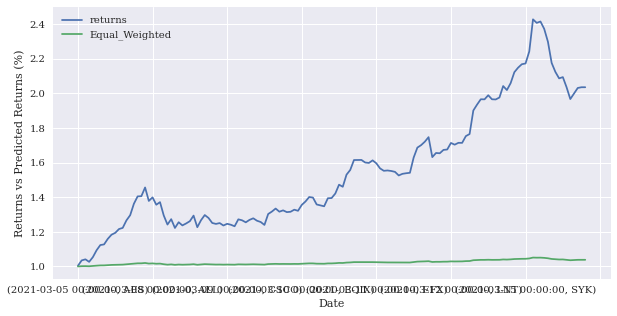

In [173]:
# Predicted Values
import seaborn as sns
import numpy as np
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
# import matplotlib.pyplot as plt
from pylab import plt
plt.style.use('seaborn')
plt.rcParams['font.family'] = 'serif'
%matplotlib inline
# stock['Predicted_Values'] = model.predict(stock[features])

# Calculate geometric returns under buy and hold strategy under real and predicted returns
geometric_returns = (competing_predictions['returns'].iloc[:]+1).cumprod()
geometric_returns_pred = (competing_predictions['Equal_Weighted'].iloc[:]+1).cumprod()
# Plot geometric returns
geometric_returns.plot(figsize=(10,5))
geometric_returns_pred.plot()

plt.ylabel("Returns vs Predicted Returns (%)")
plt.xlabel("Date")
plt.legend()
plt.show()

++++++++++++++++++++++++++++++++++++

In [24]:
with pd.HDFStore('models_DB.h5') as store:
    print(store.keys())
    true_daily = store['predictions/news/true_daily']
    daily = store['/prices/daily']
    predictions = store['predictions/news/daily']
    for i in store.keys():
        print(i,store.get_storer(i).table.description)

['/prices/daily', '/predictions/news/daily', '/predictions/news/true_daily']
/prices/daily Description([('index', '()i8'), ('ticker', '()S5'), ('date', '()i8'), ('open', '()f8'), ('close', '()f8'), ('high', '()f8'), ('low', '()f8'), ('volume', '()f8')])
/predictions/news/daily Description([('index', '()i8'), ('ticker', '()S5'), ('date', '()i8'), ('Headlines', '()S2000'), ('News Date', '()i8'), ('Predictions_V1', '()f4'), ('Predictions_V2', '()f4'), ('BUY_V1', '()i4'), ('BUY_V2', '()i4')])
/predictions/news/true_daily Description([('index', '()i8'), ('ticker', '()S5'), ('date', '()i8'), ('open', '()f8'), ('close', '()f8'), ('high', '()f8'), ('low', '()f8'), ('volume', '()f8'), ('returns', '()f8'), ('label', '()f8'), ('Predictions_V1', '()f4'), ('Predictions_V2', '()f4'), ('BUY_V1', '()i4'), ('BUY_V2', '()i4')])


In [7]:
with pd.HDFStore(DATA_PATH) as store:
        #check max date of prediction to run or kill
        df = store['predictions/news/daily'].sort_index()
        max_date = df.index.get_level_values(0).max()
with pd.HDFStore(news_db, mode = 'r') as store:
    final_df = pd.DataFrame()
    if max_date.isoweekday() == 5: predict_date = (max_date + datetime.timedelta(3)).strftime('%Y-%m-%d')
    else: predict_date = (max_date + datetime.timedelta(1)).strftime('%Y-%m-%d')
    while True:
        if pd.to_datetime(max_date).strftime('%Y-%m-%d') != predict_date:
            print('Predicting for %s news headlines!' % (predict_date))
            for i in tqdm(store.keys()):
                df = store[i]
                today = pd.to_datetime(max_date).strftime('%Y-%m-%d')
                news_today = df.loc[df.loc[:, 'versionCreated'].apply(lambda x: x.strftime('%Y-%m-%d')) == today]
                news_today = news_today[~news_today.text.duplicated()]
                if len(news_today) > 0:
                    sample = news_today.text.str.cat(sep=' ')
                    if len(sample) > 1000: sample = sample[:500] + "..." + sample[-500:]
                    else: pass   
                    temp_df = pd.DataFrame.from_dict({i.strip('/'): sample}, orient='index').rename(columns={0:'Headlines'})
                    final_df = final_df.append(temp_df)
                    final_df['date'] = predict_date
                    final_df = final_df[~final_df.Headlines.duplicated()]
                else: pass
            print(final_df.info())
            final_df['Headlines'].replace('', np.nan, inplace=True)
            final_df['News Date'] = today
            final_df.dropna(subset=['Headlines'], inplace=True)
            final_df = final_df.reset_index().rename(columns={'index':'ticker'})
            final_df = final_df.set_index((['date', 'ticker'])).sort_index(level = 0, sort_remaining=0)
            print('Data has been loaded!\nPredicting.....')
            memory()
            X = encode2bytes(final_df.Headlines.apply(lambda x: '<s>' + x + '<\s'))
            X = pad_sequences(X, maxlen =  max(map(len, X)), padding = 'post', truncating='post')
            memory()
            predictions = daily_V1.predict(X)
            print('Model 1 Done!')
            X_2 = [i.encode('utf-8') for i in final_df.Headlines.apply(lambda x: '<s>' + x + '<\s')] # encode
            tokenizer = tokenize() #tokenize
            X_2 = tokenizer.texts_to_sequences(X_2)    #pad
            X_2 = pad_sequences(X_2, maxlen =  max(map(len, X_2)), padding = 'post', truncating='post') #pad
            predictions2 = daily_V2.predict(X_2)    #predict
            memory()
            print('Model 2 Done!')
            final_df['Headlines'] = final_df['Headlines'].apply(lambda x: extract_end(x, 450)) #limit to 1000
            final_df['Predictions_V1'] = np.squeeze(predictions)
            final_df['Predictions_V2'] = np.squeeze(predictions2)
            final_df['BUY_V1'] = np.squeeze((predictions > 0.5).astype("int32"))
            final_df['BUY_V2'] = np.squeeze((predictions2 > 0.5).astype("int32"))
            final_df = final_df.round({'Predictions_V1': 5, 'Predictions_V2': 5})
            final_df['News Date'] = pd.to_datetime(final_df['News Date'])
            final_df = final_df.astype({'Predictions_V1': 'float32', 'Predictions_V2': 'float32', 'BUY_V1': 'int32', 'BUY_V2': 'int32'})
            new_tuples = final_df.index.map(lambda x: (pd.to_datetime(x[0]), x[1]))
            final_df.index = pd.MultiIndex.from_tuples(new_tuples, names=["date", "ticker"])
            sys.exit()
#             with pd.HDFStore(DATA_PATH) as store:
#                 store.put('predictions/news/daily', final_df,  encoding = 'UTF-8',format = 'table',append = True,
#                           min_itemsize={'Headlines': 2000})

Predicting for 2021-03-16 news headlines!


100%|████████████████████████████████████████████████████████████████████████████████| 543/543 [01:53<00:00,  4.76it/s]


<class 'pandas.core.frame.DataFrame'>
Index: 376 entries, A to ZM
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Headlines  376 non-null    object
 1   date       376 non-null    object
dtypes: object(2)
memory usage: 8.8+ KB
None
Data has been loaded!
Predicting.....
used: 84.8% free: 1.13GB
used: 84.8% free: 1.13GB
Model 1 Done!
used: 73.4% free: 1.96GB
Model 2 Done!


SystemExit: 

In [19]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2291 entries, (Timestamp('2021-03-05 00:00:00'), 'A') to (Timestamp('2021-03-15 00:00:00'), 'ZTS')
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Headlines       2291 non-null   object        
 1   News Date       2291 non-null   datetime64[ns]
 2   Predictions_V1  2291 non-null   float32       
 3   Predictions_V2  2291 non-null   float32       
 4   BUY_V1          2291 non-null   int32         
 5   BUY_V2          2291 non-null   int32         
dtypes: datetime64[ns](1), float32(2), int32(2), object(1)
memory usage: 82.3+ KB


In [22]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 376 entries, (Timestamp('2021-03-16 00:00:00'), 'A') to (Timestamp('2021-03-16 00:00:00'), 'ZM')
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Headlines       376 non-null    object        
 1   News Date       376 non-null    datetime64[ns]
 2   Predictions_V1  376 non-null    float32       
 3   Predictions_V2  376 non-null    float32       
 4   BUY_V1          376 non-null    int32         
 5   BUY_V2          376 non-null    int32         
dtypes: datetime64[ns](1), float32(2), int32(2), object(1)
memory usage: 15.9+ KB


In [40]:
def get_true_labels():
    def pct_change(df):
        return (df.close.shift(-1) - df.close)/ df.close
    #Get todays prices to get true label
    with pd.HDFStore(DATA_PATH) as store:
        today = store['predictions/news/daily'].index.get_level_values(0).max().strftime('%Y-%m-%d')
    with pd.HDFStore(DATA_PATH, 'r+') as store:
        daily = store['prices/daily'].sort_index()
        daily = daily[~daily.index.duplicated()] # added this when removed sys.exit() fro previous func and while loop kept uploading same data
        daily.sort_index(level=[0, 1], ascending=[1, 0], inplace=True)
        max_prices = daily.index.get_level_values(0).max()
        max_prices = (pd.to_datetime(max_prices)).strftime('%Y-%m-%d')
        store.close()
        if (max_prices == today): 
            pass
        else: 
            print("Please Upload today's closing Prices!")
            sys.exit()
    if (len(daily) > 0): 
        with pd.HDFStore(DATA_PATH) as store:
            print(store.keys())
            df = store['predictions/news/daily'].sort_index()
        daily['returns'] = daily.groupby('ticker', group_keys=False).apply(pct_change).shift(1)
        daily['label'] = daily.returns.where(daily.returns > 0, 0).where(daily.returns < 0, 1)
        daily.dropna(subset=['returns'], inplace = True)
        #fix index format to join tables on intersection
        new_tuples = df.index.map(lambda x: (pd.to_datetime(x[0]), x[1]))
        df.index = pd.MultiIndex.from_tuples(new_tuples, names=["date", "ticker"])
        #Join on intersection
        intersect = daily.index.intersection(df.index)
        df = df.loc[intersect, :].sort_index()
        daily = daily.loc[intersect, :].sort_index()
        daily = daily.join(df[['Predictions_V1', 'Predictions_V2', 'BUY_V1','BUY_V2']])
        daily = daily.loc[today]
        store.close()
        with pd.HDFStore(DATA_PATH, 'r+') as store:
            labels = store['predictions/news/true_daily']
            max_date = labels.index.get_level_values(0).max()
            if max_date.strftime('%Y-%m-%d') != today:
                store.put('predictions/news/true_daily', daily, encoding = 'UTF-8',format = 'table',append = True)
                print('+++++++++All Done!+++++++++')
                print('True stock price labels has been uploaded for %s!' % today)
            else: print('Labels already update!')
        sys.exit()
    else:sys.exit()

In [41]:
get_true_labels()

['/prices/daily', '/predictions/news/daily', '/predictions/news/true_daily']
+++++++++All Done!+++++++++
True stock price labels has been uploaded for 2021-03-15!


SystemExit: 

In [46]:
true_daily

open   close    high      low      volume   returns  \
date       ticker                                                          
2021-03-05 A       115.88  116.14  116.18  112.490    973064.0  0.010001   
           AAL      21.38   20.45   21.50   18.940  13460494.0 -0.037194   
           AAPL    120.96  121.42  121.93  117.570  36257298.0  0.010738   
           ABBV    106.01  106.70  106.98  104.080   1581353.0  0.009938   
           ABMD    297.98  301.22  302.57  281.510    155676.0  0.018909   
...                   ...     ...     ...      ...         ...       ...   
2021-03-15 XRX      26.70   26.06   26.94   26.005    613507.0 -0.031587   
           YUM     105.24  107.99  108.01  105.120    425595.0  0.030341   
           ZBH     164.04  161.47  165.49  160.570    418891.0 -0.010358   
           ZM      347.98  350.00  351.51  343.550    717286.0  0.010422   
           ZTS     152.77  154.84  155.49  152.560    680370.0  0.014878   

                   label  Predictions_V1  Predictions_V2  BUY_V1  BUY_V2  
date       ticker                                                         
2021-03-05 A         1.0         0.12770         0.31610       0       0  
           AAL       0.0         0.27590         0.02610       0       0  
           AAPL      1.0         0.34580         0.40980       0       0  
           ABBV      1.0         0.34280         0.26850       0       0  
           ABMD      1.0         0.17040         0.08840       0       0  
...                  ...             ...             ...     ...     ...  
2021-03-15 XRX       0.0         0.06732         0.05594       0       0  
           YUM       1.0         0.22638         0.11454       0       0  
           ZBH       0.0         0.23180         0.03158       0       0  
           ZM        1.0         0.28967         0.09125       0       0  
           ZTS       1.0         0.22060         0.20718       0       0  

[2697 rows x 11 columns]